In [1]:
import cv2
from glob import glob
import pandas as pd
import numpy as np

import torch

import rasterio
from rasterio.mask import mask
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = gpd.read_file("datasets/Varuna Hackathon 2022/training_area/traindata.shp")
df_test = gpd.read_file("datasets/Varuna Hackathon 2022/testing_area/testdata.shp")

grid_aoi = gpd.read_file("datasets/Varuna Hackathon 2022/Grid_AOI/AOI.shp")

df_train['area'] = df_train['geometry'].apply(lambda x: x.area)
df_test['area'] = df_test['geometry'].apply(lambda x: x.area)

df_train

,years,crop_type,geometry,area
0,2021,1,"POLYGON ((774604.014 1671240.055, 774606.506 1...",7395.766301
1,2021,1,"POLYGON ((773367.837 1670278.438, 773389.600 1...",12760.987757
2,2021,1,"POLYGON ((771648.671 1673990.960, 771707.027 1...",41971.752161
3,2021,3,"POLYGON ((771306.117 1674174.738, 771426.678 1...",8416.322100
4,2021,2,"POLYGON ((763750.339 1678588.825, 763879.691 1...",13915.426881
...,...,...,...,...
1312,2021,3,"POLYGON ((769004.617 1679027.544, 769130.199 1...",19370.802033
1313,2021,3,"POLYGON ((772624.509 1673384.254, 772770.291 1...",5249.190746
1314,2021,1,"POLYGON ((774333.243 1669788.192, 774337.269 1...",17355.845596
1315,2021,3,"POLYGON ((768880.988 1687424.354, 768996.565 1...",19346.460336


In [3]:
def extract_feature(x):
    file_sep = x.split('.')
    name_feature = file_sep[0].split('_')
    return [name_feature[2],file_sep[-1]]

file_path = glob('datasets/Varuna Hackathon 2022/sentinel-2 image/*/*/*/*')
df_img = pd.DataFrame([[i]+i.split('/')[-4:] for i in file_path],columns=['raw_path','year','yyyymmdd','filetype','filename'])
df_img = df_img[df_img['filetype']=="IMG_DATA"].reset_index(drop=True)

df_file_feat = pd.DataFrame([extract_feature(df_img['filename'][i]) for i in range(df_img.shape[0])],columns=['band','file_format'])
df_img = pd.concat([df_img,df_file_feat],axis=1)
df_img = df_img[df_img.file_format=="jp2"].reset_index(drop=True)
df_img['mm'] = df_img.yyyymmdd.apply(lambda x: x[4:6])
df_img['dd'] = df_img.yyyymmdd.apply(lambda x: x[6:])
df_img

,raw_path,year,yyyymmdd,filetype,filename,band,file_format,mm,dd
0,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_AOT.jp2,AOT,jp2,01,02
1,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B01.jp2,B01,jp2,01,02
2,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B02.jp2,B02,jp2,01,02
3,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B03.jp2,B03,jp2,01,02
4,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2020,20200102,IMG_DATA,47PQS_20200102_B04.jp2,B04,jp2,01,02
...,...,...,...,...,...,...,...,...,...
2125,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_B12.jp2,B12,jp2,12,27
2126,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_B8A.jp2,B8A,jp2,12,27
2127,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_SCL.jp2,SCL,jp2,12,27
2128,datasets/Varuna Hackathon 2022/sentinel-2 imag...,2021,20211227,IMG_DATA,47PQS_20211227_TCI.jp2,TCI,jp2,12,27


In [4]:
df_img.yyyymmdd.unique()

array(['20200102', '20200107', '20200112', '20200117', '20200122',
       '20200127', '20200201', '20200206', '20200211', '20200216',
       '20200221', '20200226', '20200302', '20200307', '20200312',
       '20200317', '20200322', '20200327', '20200401', '20200406',
       '20200411', '20200421', '20200426', '20200501', '20200506',
       '20200511', '20200516', '20200521', '20200526', '20200531',
       '20200605', '20200610', '20200615', '20200620', '20200625',
       '20200630', '20200705', '20200710', '20200715', '20200720',
       '20200725', '20200730', '20200804', '20200809', '20200814',
       '20200819', '20200824', '20200829', '20200903', '20200908',
       '20200913', '20200918', '20200923', '20200928', '20201003',
       '20201008', '20201013', '20201018', '20201023', '20201028',
       '20201102', '20201107', '20201112', '20201117', '20201122',
       '20201127', '20201202', '20201207', '20201212', '20201217',
       '20201227', '20210101', '20210106', '20210111', '202101

# Mask Preprocessing

In [12]:
# Create Mask File
from rasterio.plot import show
# shapes = [df_train.geometry[1177]] # [0]
# with rasterio.open("white.jp2") as src:
src = rasterio.open("white.jp2")
masks_train = []
for shape in df_train.geometry:
    out_image, out_transform = mask(src, [shape], crop=False)
    out_image = (out_image!=0)
    masks_train += [out_image]
masks_train = np.concatenate(masks_train)

<AxesSubplot:>

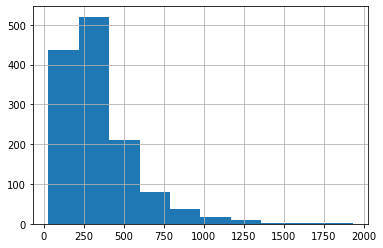

In [141]:
masks_shape = []
for shape in df_train.geometry:
    out_image, out_transform = mask(src, [shape], crop=True)
    masks_shape+=[out_image.shape[1:]]
    
df_boxshape = pd.DataFrame(masks_shape,columns=['w','h'])
df_boxshape['area'] = df_boxshape['w']* df_boxshape['h']
# df_boxshape.w.min(),df_boxshape.w.max(),df_boxshape.h.min(),df_boxshape.h.max()
df_boxshape.area.hist()

<AxesSubplot:>

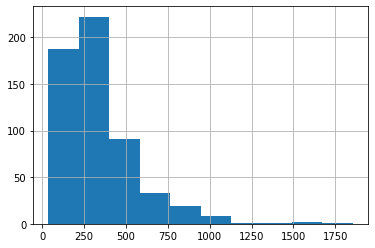

In [142]:
masks_shape = []
for shape in df_test.geometry:
    out_image, out_transform = mask(src, [shape], crop=True)
    masks_shape+=[out_image.shape[1:]]
    
df_boxshape = pd.DataFrame(masks_shape,columns=['w','h'])
df_boxshape['area'] = df_boxshape['w']* df_boxshape['h']
# df_boxshape.w.min(),df_boxshape.w.max(),df_boxshape.h.min(),df_boxshape.h.max()
df_boxshape.area.hist()

In [14]:
np.save("./datasets/masks_train.npy",masks_train)

In [15]:
masks_test = []
for shape in df_test.geometry:
    out_image, out_transform = mask(src, [shape], crop=False)
    out_image = (out_image!=0)
    masks_test += [out_image]
masks_test = np.concatenate(masks_test)
np.save("./datasets/masks_test.npy",masks_test)

# Mask Preprocessing Function

In [44]:
masks_train  = np.load("./datasets/masks_train.npy")

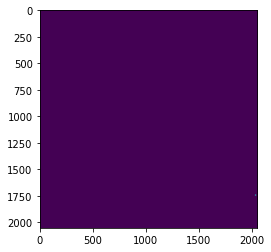

In [45]:
plt.imshow(masks_train[0])

In [145]:
def crop_data(x,full_feat = None):
    sum_0 = x.sum(axis=0)
    sum_1 = x.sum(axis=1)
    min_max_0 = np.nonzero(sum_0)[0]    
    min_max_1 = np.nonzero(sum_1)[0]
    min_0, max_0 = min(min_max_0), max(min_max_0)    
    min_1, max_1 = min(min_max_1), max(min_max_1)
    if full_feat is not None:
        return x[min_1:max_1+1,min_0:max_0+1],full_feat[min_1:max_1+1,min_0:max_0+1]
    return x[min_1:max_1+1,min_0:max_0+1]
# def pad_img(x,cropped_feat = None):
    
def pad_zero_square_img(img,min_size = 16):
    if img.ndim==2:
        H,W = img.shape
        if min_size>W:
            d = min_size-W
            pad_left = np.zeros((H,d//2+d%2))
            pad_right = np.zeros((H,d//2))
            img = np.concatenate([pad_left,img,pad_right],axis=1)
        if min_size>H:
            d = min_size-H
            pad_top = np.zeros((d//2+d%2,max(min_size,W)))
            pad_btm = np.zeros((d//2,max(min_size,W)))
            img = np.concatenate([pad_top,img,pad_btm],axis=0)
        return img
    else:
        H,W,n_dim = img.shape
        if min_size>W:
            d = min_size-W
            pad_left = np.zeros((H,d//2+d%2,n_dim))
            pad_right = np.zeros((H,d//2,n_dim))
            img = np.concatenate([pad_left,img,pad_right],axis=1)
        if min_size>H:
            d = min_size-H
            pad_top = np.zeros((d//2+d%2,max(min_size,W),n_dim))
            pad_btm = np.zeros((d//2,max(min_size,W),n_dim))
            img = np.concatenate([pad_top,img,pad_btm],axis=0)
        return img

def slicing_array(x,window_size = 16, stride = 1, mask = None, area_thresh = 0.7):
    outputs = []
    x_shape = x.shape
    H,W = x_shape[0],x_shape[1]
    for h in range((H-window_size)//stride+1):
        for w in range((W-window_size)//stride+1):
            if mask is not None:
                cropped_mask = mask[h*stride:h*stride+window_size,w*stride:w*stride+window_size]
                if cropped_mask.sum()/window_size/window_size > area_thresh:
                    outputs += [x[h*stride:h*stride+window_size,w*stride:w*stride+window_size]]
            else:
                outputs += [x[h*stride:h*stride+window_size,w*stride:w*stride+window_size]]
            # print(h*stride,h*stride+window_size,w*stride,w*stride+window_size)
    return outputs
croped_mask = crop_data(masks_train[1177])
padded_mask = pad_zero_square_img(croped_mask)
# plt.imshow(padded)
outputs = slicing_array(padded_mask, mask = padded_mask, window_size = 16, stride = 5)
# plt.imshow(padded_mask)

In [146]:
len(outputs)

16

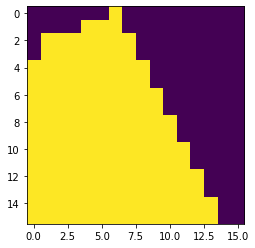

In [140]:
plt.imshow(outputs[1])

In [88]:
croped_land[0].shape

(11, 8)

In [87]:
croped_land[1].shape

(11, 8, 100)

# Sentinel2 Image Preprocessing

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,df_img, normalize = False, img_size = 2051):
        self.df_img = df_img
        self.unique_date = df_img.yyyymmdd.unique()
        self.normalize = normalize
        self.img_size = img_size

    def __len__(self):
        return len(self.unique_date)
    def __getitem__(self, idx):
        data = self.df_img[self.df_img.yyyymmdd==self.unique_date[idx]]
        data.index = data.band.values
        data = data.to_dict()
        raw_path = data['raw_path']
        raw_path['date'] = self.unique_date[idx]

        # rgb = np.concatenate([self.read_jp2(raw_path['B02'])[:,:,None],self.read_jp2(raw_path['B03'])[:,:,None],self.read_jp2(raw_path['B04'])[:,:,None]],axis=-1)
        # rgb = (rgb/3558 *255).astype('uint8')
        return raw_path# {'image': rgb}

    def read_jp2(self,x):
        elhas_raster = rasterio.open(x)
        inputArray = elhas_raster.read()[0]

        inputArray = cv2.resize(inputArray, (self.img_size,self.img_size), interpolation = cv2.INTER_AREA)
        if self.normalize:
            # vmin, vmax = np.nanpercentile(inputArray, (5,95))
            vmin,vmax = 0,3558 
            inputArray = np.clip((inputArray-vmin)/(vmax-vmin),0,1)
        
        return inputArray
dataset = ImageDataset(df_img)

In [6]:
def get_max_value(dataset):
    keys = ['B02','B03','B04','B8A','B11','B12']
    output = dict.fromkeys(keys,0)
    for i in dataset:
        for j in keys:
            value = dataset.read_jp2(i[j]).max()
            output[j] = max(output[j],value)
    return output
get_max_value(dataset)

{'B02': 32793,
 'B03': 32515,
 'B04': 27113,
 'B8A': 19794,
 'B11': 15307,
 'B12': 15486}

In [7]:
def get_max_value(dataset):
    keys = ['B05','B06','B07','B08']
    output = dict.fromkeys(keys,0)
    for i in dataset:
        for j in keys:
            value = dataset.read_jp2(i[j]).max()
            output[j] = max(output[j],value)
    return output
get_max_value(dataset)

{'B05': 25424, 'B06': 23500, 'B07': 21408, 'B08': 22171}

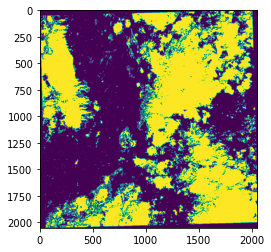

In [6]:
# Blue : 0.445 (µm) 'B02'
# Green : 0.555 (µm) 'B03'
# Red : 0.672 (µm) 'B04'
# NIR08 : 0.865 (µm) 'B8A'
# NIR13 : 1.39 (µm) 'B10'
# NIR16 : 1.61 (µm) 'B11'
# NIR22 : 2.25 (µm) 'B12'

# (Blue > MIN_REF) ^ (Green > MIN_REF) ^ (Red > MIN_REF) = CLOUD
# (NIR13 > MIN_CIRRUS) = CIRRUS
# ((Red < 4.0%) ^ (Red > NIR22)) ^ [((NIR08 > Red) ^ (Green < MIN_REF) ^ (Blue < MIN_REF) ^ (NIR08 > 5.0%)) V (NIR08 < MAX_NIR)] = SHADOW
# (NIR08 < 12%) ^ (Green > NIR08) = WATER
data_range = {'B02': 32793, 'B03': 32515, 'B04': 27113, 'B8A': 19794, 'B11': 15307, 'B12': 15486}
def read_CLOUD_mask(data):
    Blue = dataset.read_jp2(data['B02'])
    Green = dataset.read_jp2(data['B03'])
    Red = dataset.read_jp2(data['B04'])
    NIR08 = dataset.read_jp2(data['B8A'])
    NIR16 = dataset.read_jp2(data['B11'])
    NIR22 = dataset.read_jp2(data['B12'])

    MIN_REF = 0.08*32793
    CLOUD = (Blue > MIN_REF) & (Green > MIN_REF) & (Red > MIN_REF)
    SHADOW = ((Red < MIN_REF/2) & (Red > NIR22)) & (((NIR08 > Red) & (Green < MIN_REF) & (Blue < MIN_REF) & (NIR08 > 0.05*19794)) | (NIR08 < 19794))
    WATER = (NIR08 < 0.12*19794) & (Green > NIR08)
    return CLOUD | SHADOW | WATER
def read_CLOUD_mask2(data):
    SCL = dataset.read_jp2(data['SCL'])
    return (SCL==3)|(SCL==7)|(SCL==8)|(SCL==9)|(SCL==10)
    
plt.imshow(read_CLOUD_mask2(dataset[0]))

In [7]:
# NDVI = (NIR – Red) / (NIR + Red)
# SAVI = [(NIR – Red)/(NIR + Red +0.5)] ∗ (1 + 0.5)
# NDWI = (NIR - MIR) / (NIR + MIR)
def COMPUTE_features(data):
    Blue = dataset.read_jp2(data['B02']).astype(float)
    Green = dataset.read_jp2(data['B03']).astype(float)
    Red = dataset.read_jp2(data['B04']).astype(float)
    NIR = dataset.read_jp2(data['B8A']).astype(float)
    MIR = dataset.read_jp2(data['B12']).astype(float)
    
    NIR05 = dataset.read_jp2(data['B05'])
    NIR06 = dataset.read_jp2(data['B06'])
    NIR07 = dataset.read_jp2(data['B07'])
    NIR08 = dataset.read_jp2(data['B08'])
    
     
    NDVI = (NIR - Red)/(NIR + Red)
    GNDVI = (NIR - Green)/(NIR + Green)
    SAVI = ((NIR - Red)/(NIR + Red +0.5)) * (1 + 0.5)
    NDWI = (NIR - MIR) / (NIR + MIR)
    
    NDVI = np.nan_to_num(NDVI, nan=0.0)[:,:,None]
    GNDVI = np.nan_to_num(GNDVI, nan=0.0)[:,:,None]
    SAVI = np.nan_to_num(SAVI, nan=0.0)[:,:,None]
    NDWI = np.nan_to_num(NDWI, nan=0.0)[:,:,None]
    
    Blue = (Blue/20000)[:,:,None]
    Green = (Green/20000)[:,:,None]
    Red = (Red/20000)[:,:,None]
    NIR05 = (NIR05/20000)[:,:,None]
    NIR06 = (NIR06/20000)[:,:,None]
    NIR07 = (NIR07/20000)[:,:,None]
    NIR08 = (NIR08/20000)[:,:,None]
    NIR = (NIR/20000)[:,:,None]
    return np.concatenate([Blue,NIR08,NDVI,GNDVI,SAVI],axis=-1)# np.concatenate([Blue,NIR08,NDVI,GNDVI,SAVI,NDWI],axis=-1)

features = COMPUTE_features(dataset[0])
features.shape

/tmp/ipykernel_8951/3254101269.py:17: RuntimeWarning: invalid value encountered in true_divide
  NDVI = (NIR - Red)/(NIR + Red)
/tmp/ipykernel_8951/3254101269.py:18: RuntimeWarning: invalid value encountered in true_divide
  GNDVI = (NIR - Green)/(NIR + Green)
/tmp/ipykernel_8951/3254101269.py:20: RuntimeWarning: invalid value encountered in true_divide
  NDWI = (NIR - MIR) / (NIR + MIR)


(2051, 2051, 5)

In [ ]:
CLOUD_mask = np.concatenate([read_CLOUD_mask2(i)[None,:] for i in dataset])
np.save("./datasets/CLOUD_mask.npy",CLOUD_mask)

In [8]:
features = np.concatenate([COMPUTE_features(i)[None,:] for i in dataset])
features.shape

/tmp/ipykernel_8951/3254101269.py:17: RuntimeWarning: invalid value encountered in true_divide
  NDVI = (NIR - Red)/(NIR + Red)
/tmp/ipykernel_8951/3254101269.py:18: RuntimeWarning: invalid value encountered in true_divide
  GNDVI = (NIR - Green)/(NIR + Green)
/tmp/ipykernel_8951/3254101269.py:20: RuntimeWarning: invalid value encountered in true_divide
  NDWI = (NIR - MIR) / (NIR + MIR)


(142, 2051, 2051, 5)

In [9]:
np.save("./datasets/image_features_Blue_NIR08_NDVI_GNDVI_SAVI.npy",features)